# Numerické řešení Stokesova problému pomocí MKO

Stokesův problém modeluje stacionární velmi pomalé proudění vazké nestlačitelné tekutiny. Je posán následujícími rovnicemi

\begin{eqnarray}
\nabla\cdot U &=& 0, \\
\nabla p &=& \nabla \cdot(\mu \nabla U).
\end{eqnarray}

kde $p$ je tlak, $U$ je rychlost (vektor) a $\mu$ je dynamická viskozita.

Pozn. pro $\mu=konst$ lze ve druhé rovnici nahradit tlak součinem $\mu p$ a rovnice se pak zjednoduší na $\nabla p = \Delta U$.

In [1]:
using PyPlot;

In [2]:
include("mesh.jl");
include("fields.jl");
include("operators.jl");

## Definice sítě, počátečních a okrajových podmínek

In [3]:
n = 25
m = cartesian_mesh(n,n);

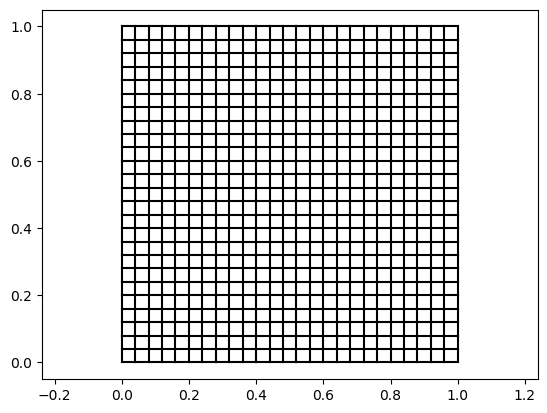

In [4]:
plot_mesh(m)
axis("equal");

In [5]:
p = ScalarField(m);
for name ∈ ["left", "right", "bottom", "top"]
    set_neumann_patch!(p, name)
end

In [6]:
u = ScalarField(m)
set_dirichlet_patch!(u, "left", 0.0);
set_dirichlet_patch!(u, "right", 0.0);
set_dirichlet_patch!(u, "bottom", 0.0);
set_dirichlet_patch!(u, "top", 1.0);

v = ScalarField(m)
set_dirichlet_patch!(v, "left", 0.0);
set_dirichlet_patch!(v, "right", 0.0);
set_dirichlet_patch!(v, "bottom", 0.0);
set_dirichlet_patch!(v, "top", 0.0);

### Sdružený algoritmus

Soustava rovnic pro řešení Stokesova problému je
$$
    \begin{bmatrix}
    L & 0 & G_x \\
    0 & L & G_y \\
    D_x & D_y & 0
    \end{bmatrix}
    \begin{bmatrix} u \\ v \\ p \end{bmatrix}
    =
    \begin{bmatrix} b_u \\ b_v \\ b_0 \end{bmatrix}.
$$
kde $L$ je matice vzniklá aproximací $-\Delta$, $G_x$ je aproximace $\partial_x$ a $G_y$ je aproximace $\partial_y$. Podobně i $D_x$ a $D_y$.

In [7]:
μ = 1.e-4;

In [8]:
eq1 = -Δ(μ, u);
eq2 = -Δ(μ, v);
eq3 = ∂x(p);
eq4 = ∂y(p);
eq5 = ∂x(u);
eq6 = ∂y(v);

In [9]:
L  = eq1.A;
Gx = eq3.A;
Gy = eq4.A;
Dx = eq5.A;
Dy = eq6.A;
O  = spzeros(length(cells(m)),length(cells(m)));

M = [L  O  Gx;
     O  L  Gy;
     Dx Dy O];

bu = -eq1.b - eq3.b;
bv = -eq2.b - eq4.b;
b0 = -eq5.b - eq6.b;
b = [bu; bv; b0];

Matice $M$ je ale singulární!

Lze to ověřit například výpočtem čísla podmíněnosti
$$
\kappa_A = ||A|| ||A^{-1}||.
$$

To by sice pro singulární matice nemělo být definované (viz $A^{-1}$ ve vzorci), nicméně pro téměř singulární matice je $\kappa$ veliké. Při odhadu $\kappa$ tak může dojít buď k chybe výpočtu z důvodu singularity matice a nebo díky zaokrouhlovací chybě výpočet proběhne a vypočtený odhad $\kappa$ bude veliký.

In [10]:
# Odhad κ
cond(Array(M))

8.029834350703744e16

Přidám proto k soustavě 1 rovnici p[end]=0. Touto rovnicí fixuji hodnotu tlaku v jednom bodě sítě. Singularita soustavy je totiž způsobena tím, že tlak je ve Stokesově problému určen až na konstantu.

In [11]:
M[end,end] = n*n;
cond(Array(M))

120001.79818025605

In [12]:
sol = M \ b;

Řešení v poli `sol` teď obsahuje složky `[u, v, p]`. Tyto složky načteme z příslušných částí `sol`.

In [13]:
uu = sol[1:n*n];
vv = sol[n*n+1:2*n*n];
pp = reshape(sol[2*n*n+1:end], (n,n))';

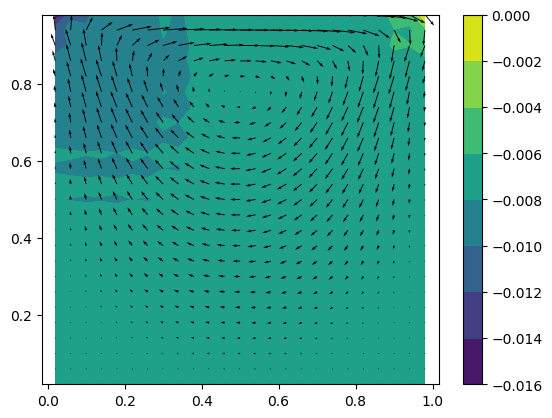

In [14]:
cx = [v[1] for v in m.centre]
cy = [v[2] for v in m.centre]

contourf(reshape(cx,(n,n))', reshape(cy,(n,n))', pp)
colorbar();  axis("equal")
quiver(cx,cy,uu,vv);

## Algoritmus SIMPLE pro Stokesuv problem

Na jednotkovém čtevrci [0,1]x[0,1] řešme soustavu rovnic
\begin{align*}
- \Delta U &= - \nabla p, \\
\nabla \cdot U &= 0.
\end{align*}

s okrajovými podmínkami
$$
    U(x,y) = \left\{
    \begin{array}{ll}
        (1,0) & \text{pro } x \in [0,1] \land y=1,\\
        (0,0) & \text{pro } x=0 \lor x=1 \lor y=0.
    \end{array}
    \right.
$$
a
$$
    \frac{\partial p}{\partial n} = 0 \,\text{pro } x=0 \lor x=1 \lor y=0 \lor y=1.
$$


Diskretizace:
$$
    a_C U_C = \sum_{f} a_F U_F + Q_C - \nabla p_C = H(U)_C - \nabla p_C,
$$

a tedy

$$
    U_C = \frac{1}{a_C} H(U)_C - \frac{1}{a_C} \nabla p_C.
$$

Definujme
$$
    \hat{U}_C = \frac{1}{a_C} H(U)_C.
$$

Rovnice kontinuity

$$
    0 = \nabla \cdot U_C = \nabla \cdot (\hat{U}_C - \frac{1}{a_C} \nabla p_C)
$$

a tedy

$$
    \nabla\cdot(\frac{1}{a_C} \nabla p_C) = \nabla \cdot \hat{U}_C.
$$

Výsledná rovnice pro tlak však stále obsahuje neznámé rychlosti. Algoritmus SIMPLE řeší danou soustavu rovnic iteračně s tím, že se řeší zvlášť rovnice pro rychlosti a zvlášť rovnice pro tlak.

### Algortimus SIMPLE ve variantě s korekcemi tlaku a rychlosti

V této variantě algoritmu SIMPLE vycházíme ze stavu $U^n$ a $p^n$ a pokusíme se vypočítat novou aproximaci $U^{n+1}$ a $p^{n+1}$.

1. Řešíme rovnici pro rychlost s tlakem $p^n$, tj. $U^*_C = \frac{1}{a_c} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n$.
Tato nová rychlost $U^*$ však nesplňuje rovnici kontinuity a navíc byla vypočtena pomocí $p^n$ a nikoliv zatím neznámého $p^{n+1}$.
2. Označme $U' = U^{n+1} - U^*$ a $p'=p^{n+1}-p^n$ a odečtěme od rovnice pro rychlost v iteraci $n+1$ rovnici pro $U^*$, tedy (za předpokladu linearity $H$)
$$
\begin{array}{rll}
U^{n+1}_C &= \frac{1}{a_C} H(U^{n+1})_C - \frac{1}{a_C} \nabla p_C^{n+1}, & \\
U^*_C &= \frac{1}{a_C} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n, & \cdot(-1) \\
\hline \\
U'_C &= \frac{1}{a_C} H(U')_C - \frac{1}{a_C} \nabla p'_C. & 
\end{array}
$$
3. Rovnice pro $U'$ však opět svazuje $U'$ a $p'$. Proto v rovnici **zanedbáme** člen s $H(U')$ a dostáváme vztah pro korekci rychlosti
\begin{equation}
    U'_C \approx - \frac{1}{a_C}\nabla p_C.
\end{equation}
4. Z rovnice kontinuity pro $U^{n+1}$ dostáváme $0 = \nabla\cdot U^{n+1} = \nabla\cdot U^* + \nabla\cdot U'$ a tedy
\begin{equation}
    \nabla\cdot(\frac{1}{a_C}\nabla p') = \nabla\cdot U^*.
\end{equation}
Tuto rovnici rovnici doplníme vhodnými okrajovými podmínkami pro $p'$ (tj. tak, aby $p^{n+1} = p^n + p'$ splňovalo zadané podmínky pro tlak) a určíme $p'$ a $p^{n+1}$.
5. Z rovnice pro korekci rychlosti určíme $U' = - \frac{1}{a_C}\nabla p'_C$ a $U^{n+1}=U^* + U'$.
6. Celý postup opakujeme dokud není $||U'||$ a $||p'||$ dostatečně malá.

### Algoritmus SIMPLE ve variantě s tlakem

Tato varianta je velmi podobná předchozímu algoritmu. Narozdíl od něj však nepočítá s korekcemi tlaku ale přímo s tlakem.

1. Řešíme rovnici pro rychlost s tlakem $p^n$, tj. $U^*_C = \frac{1}{a_c} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n$.
2. Označme $\hat U = \frac{1}{a_c} H(U^*)_C$. Potom
\begin{equation}
U^{n+1}_C = \left[\frac{1}{a_c} H(U^{n+1})_C - \hat{U}\right] + \hat{U} - \frac{1}{a_C} \nabla p_C^{n+1}.
\end{equation}
Stejně jako v předchozí variantě **zanedbáme** výraz v hranaté závorce na pravé straně a dostáváme
\begin{equation}
U^{n+1}_C \approx \hat{U} - \frac{1}{a_C} \nabla p_C^{n+1}.
\end{equation}
3. Z rovnice kontinuity pro $U^{n+1}$ dostáváme $0 = \nabla\cdot U^{n+1} = \nabla\cdot \left(\hat{U} - \frac{1}{a_C}\nabla p^{n+1}_C\right)$ a tedy
\begin{equation}
    \nabla(\frac{1}{a_C}\nabla p^{n+1}) = \nabla\cdot \hat{U}.
\end{equation}
4. Z rovnice pro rychlost určíme $U^{n+1} = \hat{U} - \frac{1}{a_C}\nabla p_C^{n+1}$.
5. Celý postup opakujeme dokude není $||U^{n+1}-U^n||$ a $||p^{n+1}-p^n||$ dostatečně malá.

In [15]:
U = VectorField(m)
set_dirichlet_patch!(U, "left", Vector(0,0));
set_dirichlet_patch!(U, "right", Vector(0,0));
set_dirichlet_patch!(U, "bottom", Vector(0,0));
set_dirichlet_patch!(U, "top", Vector(1,0));
p ← 0.0;

Ručně provedeme 1 iteraci algoritmu SIMPLE:

In [16]:
Ueqn = - Δ(μ, U);

In [17]:
solve!(Ueqn + grad(p));

In [18]:
ra = 1 ./ Ac(Ueqn);

In [19]:
Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);

In [20]:
ra .* H(Ueqn);

In [21]:
pEqn = Δ(ra, p) - div(Ubar);

Diskretizovaná rovnice pro tlak s Neumannovskými podmínkami má však singulární matici. Proto přidáme k rovnici v bodě 1 $K$-násobek rovnice $p_1=0$. To se projeví přidáním $K$ k prvku $A[1,1]$. Hodnotu $K$ přitom volíme tak, aby (zhruba) odpovídala velikosti $A[1,1]$.

Z rovnice pro rychlost vidíme, že na kartézské síti ve 2D je ve vnitřním bodě sítě
$$
  ra = \frac{h^2}{4\mu}
$$

Dosazením do rovnice pro tlak je v tomto bodě
$$
  A[1,1] = - \frac{h^2}{4\mu} \frac{4}{h^2} = - \frac{1}{\mu}.
$$

In [22]:
# diagonalni prvek pro bunku odpovidajici cca stredu oblasti
pEqn.A[312,312]

-10000.0

In [23]:
-1/μ

-10000.0

In [24]:
# diagonalni prvek v bode 1 (ten je ovlivnen okrajovymi podminkami)
pEqn.A[1,1]

-3666.6666666666656

In [25]:
solve!(pEqn)

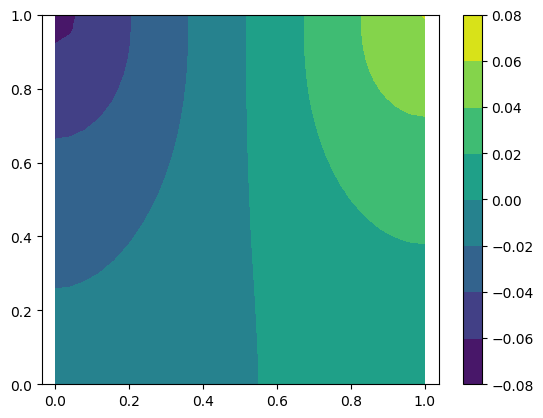

In [26]:
plot_contourf(p)
axis("equal"); colorbar();

In [27]:
U ← Ubar - ra .* grad(p);

In [28]:
component(f::VectorField, c) = [ v[c] for v in f.values ]

component (generic function with 1 method)

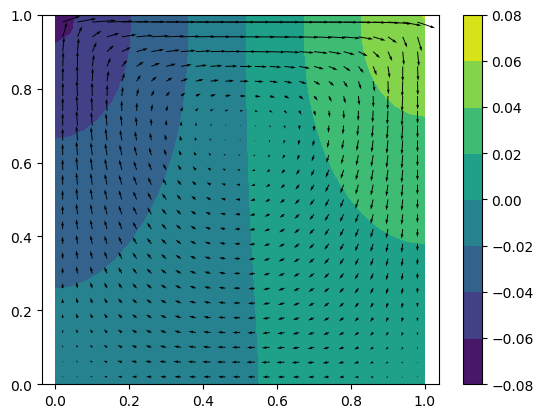

(0.0, 1.0, 0.0, 1.0)

In [29]:
plot_contourf(p); colorbar();
plot_arrows(U);
axis("equal")

Výše uvedený postup bychom měli opakovat dokud řešení nezkonverguje ke stacionárnímu stavu.

Zkusíme provést několik iterací:

In [30]:
p ← 0.0
U ← Vector(0,0);

for iter = 0:50
    
    U_old, p_old = copy(U.values), copy(p.values)
    
    Ueqn = -Δ(μ,U)

    solve!(Ueqn + grad(p))
    
    ra = 1 ./ Ac(Ueqn);
    
    Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);
    
    pEqn = Δ(ra, p) - div(Ubar);
    pEqn.A[1,1] -= 1/μ

    solve!(pEqn)
    
    U ← Ubar - ra .* grad(p)
    
    if rem(iter,5)==0
        nxny = n*n
        pRez = norm(p_old - p.values) / nxny
        URez = norm(U_old - U.values) / nxny
        println(iter, "\t", pRez, "\t", URez)
    end
end

0	0.0010822601278975242	0.0074786027331693004
5	1.9852261989526276e7	5.418067661052335e7
10	3.214472815822504e17	8.752312047871419e17
15	5.19328308820385e27	1.413995865370508e28
20	8.390105446347867e37	2.284407172606671e38
25	1.3554790042036535e48	3.6906162587209583e48
30	2.1898691753735859e58	5.962443356187659e58
35	3.5378836487736185e68	9.632735641842778e68
40	5.715693363337064e78	1.5562344227444036e79
45	9.234094127154024e88	2.514203304837386e89
50	1.4918311555356117e99	4.061867650317e99


Je vidět, že algoritmus **DIVERGUJE**

### Relaxace v algoritmu SIMPLE

Významnou roli v algoritmu SIMPLE hraje řešení soustav rovnic pro $U$ a $p$. Zatímco soustava rovnic pro $p$ vznikne diskretizací Poissonovy rovnice (a je tedy při vhodné diskretizaci symetrická a pozitivně definitní), soustava pro $U$ už symetrická být nemusí (díky konvektivním členům). Navíc v rovnici pro $U'$ zanedbáváme člen $H(U')/a_C$ a chtěli bychom, aby tento člen byl vzhledem k $U'$ malý. Proto je nutné v rovnici pro rychlost použí **relaxaci**.

Mějme soustavu lineárních rovnic $Ax=b$. Označme $x^*$ přesné řešení této soustavy a $x^n$ $n$-tou iteraci níže popsané relaxační metody. Tu získáme tak, že k řešíme místo původní soustavy soustavu vzniklou součtem $A x^{n+1} = b$ s vhodným násobek $Dx^{n+1}=Dx^n$, kde $D=diag(A)$, tedy
\begin{equation}
  A x^{n+1} + \frac{1-\alpha}{\alpha} D x^{n+1} = b + \frac{1-\alpha}{\alpha} D x^n,
\end{equation}
neboli
\begin{equation}
  \left(\frac{D}{\alpha} + (A-D)\right) x^{n+1} = b + \frac{1-\alpha}{\alpha} D x^n.
\end{equation}
Při vhodné volbě $\alpha \in (0,1)$ je matice relaxované soustavy ODD. 

To má význam i pro odhad velikosti $H(U')$. Je-li $U' \approx const.$, pak $H(U')_C/a_C \approx \alpha U'_C$ a tedy lze tento člen v algoritmu SIMPLE zanedbat.

Dalším místem, kde v algoritmu SIMPLE zanedbáváme člen $H(U')$, je vztah pro $U'_C$. Provedeme-li relaxaci rovnice pro rychlost, pak lepší odhad korekce rychlosti bude
$$
    U'_C = \frac{1}{a_C} H(U')_C - \frac{1}{a_C} \nabla p'_C \approx \alpha U'_C - \frac{1}{a_C} \nabla p'_C,
$$
tedy pro $\beta = 1 - \alpha$
$$
    U'_C = - \frac{1}{\beta a_C} \nabla p'_C.
$$
Označme $p" = p'_C / \beta$. Potom $U'_C = - \frac{1}{a_C} \nabla p"_C$ a $p"$ najdeme řešením původní rovnice
\begin{equation}
    \nabla\cdot(\frac{1}{a_C}\nabla p") = \nabla\cdot U^*.
\end{equation}
Tlak $p^{n+1}$ nakonec upravíme dle vztahu $p^{n+1} = p^n + p' = p^n + \beta p"$.

Ve variantě s korekcí rychlosti tedy
1. Relaxujeme rovnici pro rychlost s relaxačním parameterem $\alpha \in (0,1)$.
2. Postupujeme dle standardního algoritmu SIMPLE s tím, že k tlaku přidáváme pouze $\beta$-násobek korekce.

Vhodné relxační parametry jsou $\alpha + \beta \approx 1$, často $\alpha=0.7$ a $\beta = 0.3$.

Celý algoritmus SIMPLE včetně relaxace bude tedy ve variantě s výpočtem tlaku vypadat následovně:

In [31]:
p ← 0.0
U ← Vector(0,0);

α = 0.7
β = 0.3

for iter = 0:50
    
    U_old, p_old = copy(U.values), copy(p.values)
    
    Ueqn = -Δ(μ,U)

    relax!(Ueqn, α)
    
    solve!(Ueqn + grad(p))
    
    ra = 1 ./ Ac(Ueqn);
    
    Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);
    
    pEqn = Δ(ra, p) - div(Ubar);
    pEqn.A[1,1] -= α/μ

    solve!(pEqn)
    
    p ← β*p + (1-β)*p_old
    U ← Ubar - ra .* grad(p)
    
    if rem(iter,5)==0
        nxny = n*n
        pRez = norm(p_old - p.values) / nxny
        URez = norm(U_old - U.values) / nxny
        println(iter, "\t", pRez, "\t", URez)
    end
end

0	3.954386650172496e-5	0.003163301495748927
5	8.056242457412622e-6	0.0006441976603973864
10	1.745121478795265e-6	0.00026851516499101004
15	1.6278778503933052e-6	0.0001556614053905297
20	7.789914849081416e-7	0.00010629255136366686
25	2.663636409866318e-7	7.61390113312426e-5
30	6.477468568537342e-8	5.6156610040748246e-5
35	1.2403007978091426e-8	4.22509911638249e-5
40	6.28225480228712e-9	3.221046544787941e-5
45	6.019827881791119e-9	2.4782509432768204e-5
50	6.034119432285648e-9	1.919523383747767e-5


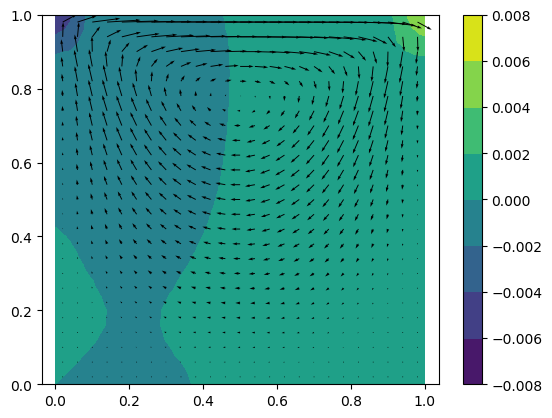

(0.0, 1.0, 0.0, 1.0)

In [32]:
plot_contourf(p); colorbar();
plot_arrows(U);
axis("equal")

In [33]:
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

In [34]:
# Ψ_x = v, Ψ_y = - u

function streamfunction(u, v, Δx=1, Δy=1)
    Ψ1 = zero(u)

    Ψ1[1,1] = 0.0
    for i=2:size(u,1)
        Ψ1[i,1] = Ψ1[i-1,1] + Δx * (v[i,1]+v[i-1,1])/2
    end
    for j=2:size(u,2)
        Ψ1[:,j] = Ψ1[:,j-1] - Δy * (u[:,j]+u[:,j-1])/2
    end

    Ψ2 = zero(Ψ1)
    
    Ψ2[1,1] = 0.0
    for j=2:size(u,2)
        Ψ2[1,j] = Ψ2[1,j-1] - Δy * (u[1,j]+u[1,j-1])/2
    end
    for i=2:size(u,1)
        Ψ2[i,:] = Ψ2[i-1,:] + Δx * (v[i,:]+v[i-1,:])/2
    end
    
    Ψ = (Ψ1 + Ψ2) / 2
    return Ψ
end

streamfunction (generic function with 3 methods)

In [35]:
Ψ = streamfunction(uu,vv,1/25,1/25);

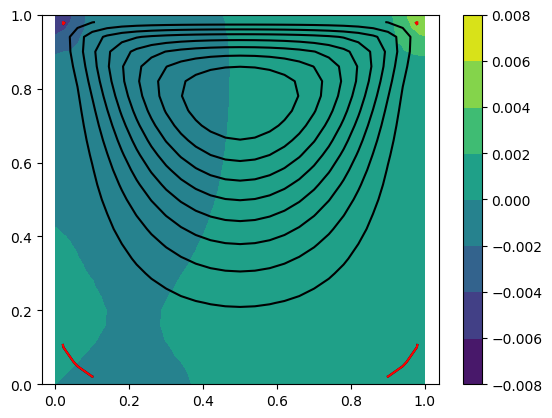

In [36]:
contour(reshape(cx,(n,n)), reshape(cy,(n,n)), reshape(Ψ,(n,n)), range(0,maximum(Ψ),length=10), colors="black");
contour(reshape(cx,(n,n)), reshape(cy,(n,n)), reshape(Ψ,(n,n)), range(minimum(Ψ),0,length=10), colors="red");
plot_contourf(p); colorbar();
axis("equal");

Totéž na jemnější síti

In [37]:
nf=50;
mf = cartesian_mesh(nf,nf);

In [38]:
pf = ScalarField(mf);
for name ∈ ["left", "right", "bottom", "top"]
    set_neumann_patch!(pf, name)
end

In [39]:
Uf = VectorField(mf)
set_dirichlet_patch!(Uf, "left", Vector(0,0));
set_dirichlet_patch!(Uf, "right", Vector(0,0));
set_dirichlet_patch!(Uf, "bottom", Vector(0,0));
set_dirichlet_patch!(Uf, "top", Vector(1,0));

In [40]:
α = 0.7
β = 0.3

for iter = 0:200
    
    U_old, p_old = copy(Uf.values), copy(pf.values)
    
    Ueqn = -Δ(μ,Uf)

    relax!(Ueqn, α)
    
    solve!(Ueqn + grad(pf))
    
    ra = 1 ./ Ac(Ueqn);
    
    Ubar = VectorField(ra .* H(Ueqn), Uf.mesh, Uf.boundaries);
    
    pEqn = Δ(ra, pf) - div(Ubar);
    pEqn.A[1,1] -= α/μ
    solve!(pEqn)
    
    pf ← β*pf + (1-β)*p_old
    Uf ← Ubar - ra .* grad(pf)
    
    if rem(iter,10)==0
        nxny = nf*nf
        pRez = norm(p_old - pf.values) / nxny
        URez = norm(U_old - Uf.values) / nxny
        println(iter, "\t", pRez, "\t", URez)
    end
end

0	3.9379457172874146e-5	0.0011611564177153332
10	1.0489250342791863e-6	0.00012036686861596944
20	1.0324717758408478e-6	6.069723874741013e-5
30	1.4015841293510713e-7	4.086872842453529e-5
40	2.4189332807793004e-8	3.0301242146274417e-5
50	2.1747870263312317e-8	2.3646813695293e-5
60	1.7376601645836254e-8	1.9040678875467713e-5
70	1.2903774175731714e-8	1.5655501914211847e-5
80	9.80898968481186e-9	1.3063456830094027e-5
90	7.65825947400577e-9	1.101993189421841e-5
100	6.082844692047844e-9	9.373985530473466e-6
110	4.888089617151349e-9	8.026648855959152e-6
120	3.9605475141033595e-9	6.909785316313276e-6
130	3.227785871163617e-9	5.974612165703855e-6
140	2.6414801333923937e-9	5.185093308008976e-6
150	2.168162954057708e-9	4.5139356045962825e-6
160	1.7837631891174593e-9	3.940049012088611e-6
170	1.4703557791562558e-9	3.4468684717288596e-6
180	1.2141961536385876e-9	3.021205162228287e-6
190	1.004500649384674e-9	2.652436053714866e-6
200	8.326650723099685e-10	2.3319176377559002e-6


In [41]:
uuf = reshape(component(Uf,1), (nf,nf));
vvf = reshape(component(Uf,2), (nf,nf));
ppf = reshape(pf.values, (nf,nf));

In [42]:
Ψf = streamfunction(uuf,vvf,1/nf,1/nf);

In [43]:
cxf = [v[1] for v in mf.centre];
cyf = [v[2] for v in mf.centre];

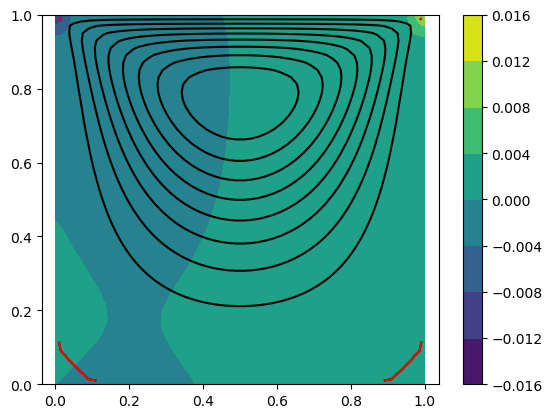

In [44]:
contour(reshape(cxf,(nf,nf)), reshape(cyf,(nf,nf)), reshape(Ψf,(nf,nf)), range(0,maximum(Ψf),length=10), colors="black");
contour(reshape(cxf,(nf,nf)), reshape(cyf,(nf,nf)), reshape(Ψf,(nf,nf)), range(minimum(Ψf),0,length=10), colors="red");
plot_contourf(pf); colorbar();
axis("equal");